# THIS NOTEBOOK IS DEDICATED TO IMMOBILE CONDITION


In [2]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
import types
warnings.filterwarnings("ignore")
import sys, time
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from pylab import *
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA


root='/data'
%run UtilityTools.ipynb
%run Animal_Tags.ipynb
%run Lesion_Size.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb

defaultParam={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }

### plotting correct trajectories aligned on detector crossing

In [31]:
profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['0'],
         'Speed':'0',
         'Tag':['ImmobileTreadmill']
         }
animalList=batch_get_animal_list(root,profile)
print(animalList)

NbSession=5
Win=2

treadmillRange=[10,90]

['Rat121', 'Rat122', 'Rat123', 'Rat124', 'Rat131', 'Rat132']


In [4]:
# def positions(data):
#     """
#     return good trajectories
#     """
#     posDict=data.position
#     time=data.rawTime #align on camera
#     pos=[]
#     for trial in posDict:
#         if trial not in data.goodTrials:
#             continue
#         pos.append(posDict[trial])
#     return pos

def posAlignEnd(data):
    """
    return good trajectories
    """
    posDict=data.position
    time=data.rawTime #align on camera
    pos=[]
    for trial in posDict:
        if trial not in data.goodTrials:
            continue
        et=data.entranceTime[trial]
        fs=data.cameraSamplingRate
        delay=data.cameraToTreadmillDelay
        assert et>=7,"Fuck!!!"
        th=int((et+delay)*fs)
        pos.append(posDict[trial][th-int(Win*fs):th])
    return pos

pos={}
for animal in animalList:
    data=data_fetch(root,animal,profile,[posAlignEnd], NbSession=NbSession)
    pos[animal]=[position for session in data[posAlignEnd.__name__] for position in session]

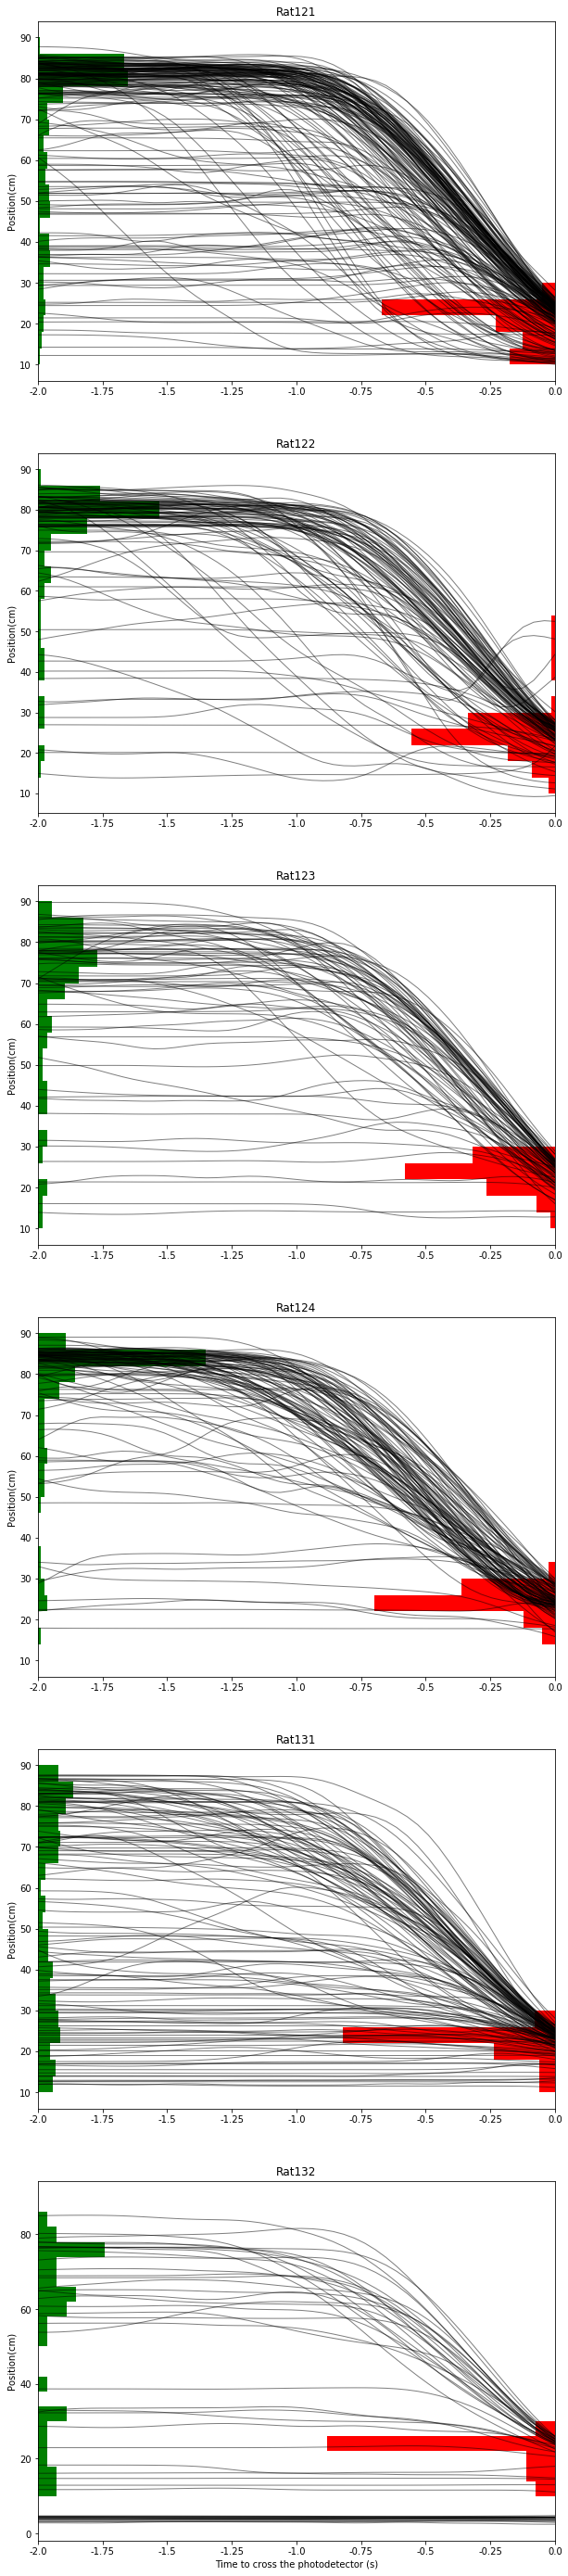

In [58]:
axes=plt.subplots(len(animalList),1,figsize=(10,50))

for i,animal in enumerate(animalList):
    data=np.array(pos[animal]).T
    t=np.linspace(-Win,0,data.shape[0])
    axes[1][i].plot(t,data,color='k',linewidth=1,alpha=.5)
    histT0,bins0=np.histogram(data[0,:],20,range=(treadmillRange[0],treadmillRange[1]), density=True)
    histT1,bins1=np.histogram(data[-1,:],20,range=(treadmillRange[0],treadmillRange[1]), density=True)
    axes[1][i].barh(bins0[:-1],histT0*5,height=np.diff(bins0)[0],align='edge',left=-Win,color='g')
    axes[1][i].barh(bins1[:-1],-histT1*5,height=np.diff(bins1)[0],align='edge',left=0,color='r')
    
    axes[1][i].set_xlim([-Win,0])
    axes[1][i].set_title(animal)
    Nticks=len(axes[1][i].get_xticks())
    axes[1][i].set_xticklabels(np.linspace(-Win,0,Nticks))
    axes[1][i].set_ylabel('Position(cm)')

#     axes[1][i].spines['left'].set_position(('data',-.5))
#     axes[1][i].spines['right'].set_position(('data',Win+.5))

axes[1][i].set_xlabel('Time to cross the photodetector (s)');